In [1]:
import sys

sys.path.append('../')

In [54]:
import pandas as pd
import numpy as np

In [3]:
start_date = '2021-01-01'
end_date = '2021-08-30'

In [4]:
tic_list = ['ETH-USD']

In [5]:
tech_indicators = ['macd',
 'rsi_30',
 'cci_30',
 'dx_30']

In [6]:
cwd = './CryptoModel/model.pkl'

In [7]:
from neo_finrl.data_processors.processor_yahoofinance import YahooFinanceProcessor

In [8]:
data_downloader = YahooFinanceProcessor()

### Extract historical px

In [ ]:
stock_history_df = data_downloader.download_data(start_date, end_date, tic_list, '1D')

In [ ]:
data_downloader.time_interval = '1D'
stock_history_df = data_downloader.clean_data(stock_history_df)

In [ ]:
stock_history_df = data_downloader.add_technical_indicator(stock_history_df, tech_indicators)

In [ ]:
stock_history_df.to_csv('./ETH_hist.csv', index = False)

### Env module

In [9]:
from test_env.single_crypto_env import CryptoTradingEnv

### Setup env

In [10]:
stock_history_df = pd.read_csv('./ETH_hist.csv')

In [11]:
price_array = stock_history_df[['open', 'adjcp', 'low', 'high']].values
tech_array = stock_history_df[tech_indicators].values

In [12]:
train_test_split_index = int(stock_history_df.shape[0] * 0.8)

In [13]:
print (f'{train_test_split_index} records for training')
print (f'{stock_history_df.shape[0] - train_test_split_index} records for testing')

193 records for training
49 records for testing


In [14]:
config = dict()

config['price_array'] = price_array[:train_test_split_index]
config['tech_array'] = tech_array[:train_test_split_index]
config['if_train'] = True

initial_capital = 1e5
max_step = 30

In [15]:
crypto_env = CryptoTradingEnv(config, initial_capital=initial_capital, max_step = max_step)

### Train RL

In [16]:
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv

In [79]:
env_train = DummyVecEnv([lambda : crypto_env])
model_name = 'ppo'

if model_name == 'ppo':
    model = PPO("MlpPolicy", env_train, learning_rate=0.00025, 
                            n_steps=1024, batch_size=128, ent_coef=0.0, 
                            gamma=0.99, seed=312)
elif model_name == 'ddpg':
    model = DDPG("MlpPolicy", env_train, learning_rate=0.00025, 
                 batch_size=128, gamma = 0.99, seed=312)

In [80]:
model.learn(total_timesteps=1e4, tb_log_name = 'ppo')
print('Training finished!')

Episode Return:  13072.026
Episode Return:  10883.105
Episode Return:  5742.6035
Episode Return:  358.44736
Episode Return:  7.1777345e-06
Episode Return:  5.288009
Episode Return:  46.59461
Episode Return:  103.4809
Episode Return:  79.938614
Episode Return:  1.4257813e-05
Episode Return:  55.727413
Episode Return:  48.05462
Episode Return:  2.9467774e-05
Episode Return:  39.94243
Episode Return:  98.712845
Episode Return:  53.452946
Episode Return:  4.593506e-05
Episode Return:  4.1381834e-05
Episode Return:  31.13654
Episode Return:  75.015236
Episode Return:  110.95894
Episode Return:  138.62434
Episode Return:  21.209429
Episode Return:  67.83373
Episode Return:  47.170033
Episode Return:  40.67934
Episode Return:  130.62146
Episode Return:  169.76506
Episode Return:  68.43497
Episode Return:  60.10086
Episode Return:  5.4162596e-05
Episode Return:  23.515745
Episode Return:  8.126746
Episode Return:  4.330597e-05
Episode Return:  54.967438
Episode Return:  0.08873429
Episode Retu

Episode Return:  182.7858
Episode Return:  257.7812
Episode Return:  279.4274
Episode Return:  337.03714
Episode Return:  351.79706
Episode Return:  282.53687
Episode Return:  79.79609
Episode Return:  147.91762
Episode Return:  198.31194
Episode Return:  165.80844
Episode Return:  211.44505
Episode Return:  216.41747
Episode Return:  258.59738
Episode Return:  348.31458
Episode Return:  318.0464
Episode Return:  348.78787
Episode Return:  410.68335
Episode Return:  429.93567
Episode Return:  509.21448
Episode Return:  759.9385
Episode Return:  749.0982
Episode Return:  1006.18695
Episode Return:  978.90955
Episode Return:  972.2399
Episode Return:  1184.6677
Episode Return:  1100.0002
Episode Return:  1400.6208
Episode Return:  1436.5416
Episode Return:  1032.8033
Episode Return:  1235.1842
Episode Return:  1046.922
Episode Return:  1059.6608
Episode Return:  510.02032
Episode Return:  523.556
Episode Return:  572.5326
Episode Return:  442.14838
Training finished!


In [81]:
model.save(cwd)
print('Trained model saved in ' + str(cwd))

Trained model saved in ./CryptoModel/model.pkl


### Test RL

In [82]:
#test on the testing env
def testRun(model, env_instance):
    state = env_instance.reset()
    episode_returns = list()  # the cumulative_return / initial_account
    done = False

    while not done:
        action = model.predict(state)[0]
        #print (action)
        state, reward, done, _ = env_instance.step(action)
        
        #print (env_instance.stocks)
        #total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day + env_instance.run_index, 1] \
        #                                     * env_instance.stocks).sum()
        #episode_return = total_asset / env_instance.initial_total_asset
        
        episode_returns.append(reward)
        
    print('episode_return', episode_returns[-1])
    print('Test Finished!')  
    return episode_returns

In [83]:
test_config = dict()

start_idx = train_test_split_index
test_config['price_array'] = price_array[start_idx:]
test_config['tech_array'] = tech_array[start_idx:]
test_config['if_train'] = False

initial_capital = 1e5
max_step = min(test_config['price_array'].shape[0], 30)

In [93]:
test_env = CryptoTradingEnv(test_config, \
                            initial_capital=initial_capital, \
                            max_step = max_step)

#test_env = CryptoTradingEnv(test_config, \
#                            initial_capital=0, \
#                            max_step = max_step, \
#                           initial_stocks = np.array([20.0]))

test_model = PPO.load(cwd)
#test_model = model
test_model = test_model.policy.eval()

In [94]:
cumulative_return = testRun(test_model, test_env)

Episode Return:  45.8977
episode_return 45.8977
Test Finished!


In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'time')

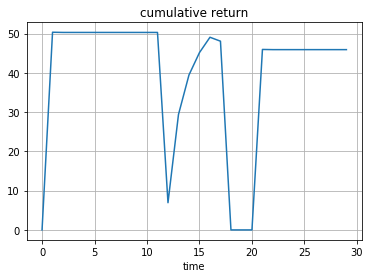

In [96]:
plt.plot(cumulative_return, label='agent return')
plt.grid()
plt.title('cumulative return')
plt.xlabel('time')